Epoch 1/10
45/45 [==============================] - 10s 219ms/step - loss: 2.3045 - accuracy: 0.3174 - val_loss: 0.9933 - val_accuracy: 0.7375
Epoch 2/10
45/45 [==============================] - 10s 217ms/step - loss: 0.4792 - accuracy: 0.8465 - val_loss: 0.3139 - val_accuracy: 0.9125
Epoch 3/10
45/45 [==============================] - 10s 220ms/step - loss: 0.1059 - accuracy: 0.9674 - val_loss: 0.2864 - val_accuracy: 0.9125
Epoch 4/10
45/45 [==============================] - 10s 220ms/step - loss: 0.0862 - accuracy: 0.9701 - val_loss: 0.1853 - val_accuracy: 0.9563
Epoch 5/10
45/45 [==============================] - 10s 221ms/step - loss: 0.0325 - accuracy: 0.9924 - val_loss: 0.0469 - val_accuracy: 0.9812
Epoch 6/10
45/45 [==============================] - 10s 221ms/step - loss: 0.0053 - accuracy: 0.9979 - val_loss: 0.1140 - val_accuracy: 0.9750
Epoch 7/10
45/45 [==============================] - 10s 221ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0816 - val_accuracy: 0.9812

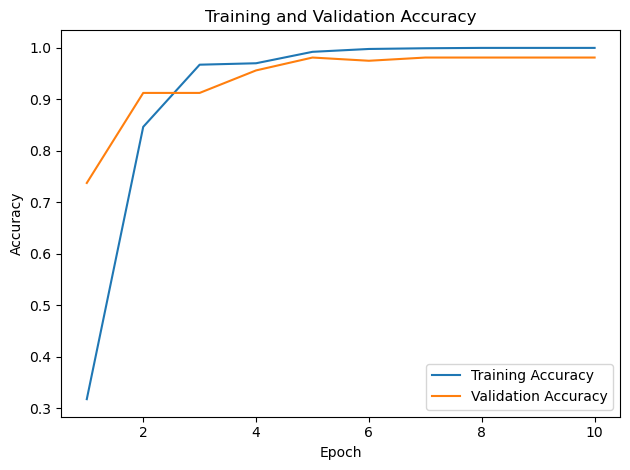

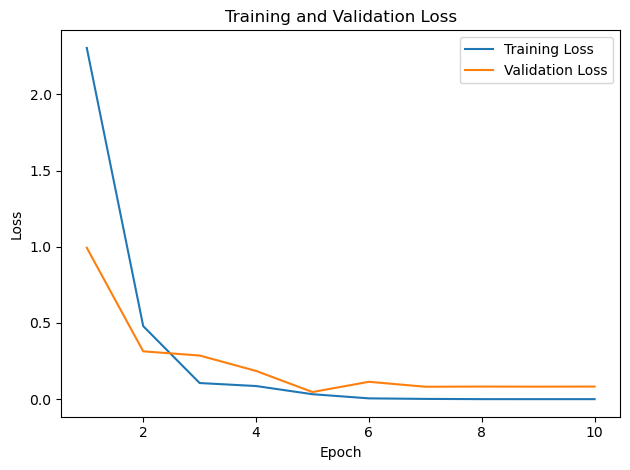

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Data = "C:/Users/USER/Project10/Dataset/train"
Categories = ["ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma", "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya"]

img_size = 100

# Function to create training data
def create_training_data():
    training_data = []
    for CATEGORY in Categories:
        path = os.path.join(Data, CATEGORY)
        class_num = Categories.index(CATEGORY)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Use IMREAD_COLOR for RGB images
                img_array = cv2.resize(img_array, (img_size, img_size))
                inverted_img_array = 255 - img_array  # Invert the colors
                training_data.append([inverted_img_array, class_num])
            except Exception as e:
                pass
    random.shuffle(training_data)
    return training_data

training_data = create_training_data()

x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)

x = np.array(x).reshape(-1, img_size, img_size, 3)  # Use 3 channels for RGB images

# Normalize and one-hot encode the labels
x = x / 255.0
y = to_categorical(y, num_classes=len(Categories))

# Split data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Further split training data into 70% training and 10% validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Load the pre-trained DenseNet121 model without the top (fully connected) layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create your own classifier (top layers)
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))

# Change the output layer to match the number of classes
model.add(Dense(len(Categories)))
model.add(Activation("softmax"))  # Use softmax activation for multiclass classification

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Training the model with validation data
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
